In [29]:
import numpy as np
from sympy.utilities.iterables import multiset_permutations

In [30]:
def dcg(real_score, predicted_score):
    real_score_ordered_by_prediction = real_score[np.argsort(-predicted_score)]
    return np.sum( (2 ** real_score_ordered_by_prediction - 1) / np.log2(np.arange(2, real_score.size + 2)))

def ndcg(real_score, predicted_score):
    return dcg(real_score, predicted_score) / dcg(real_score, real_score)

In [35]:
real_score = np.array([3, 5, 8])

In [43]:
for predicted_score in multiset_permutations(np.array([4, 5, 6])):
    print(predicted_score,  ndcg(real_score, np.array(predicted_score)))

[4, 5, 6] 1.0
[4, 6, 5] 0.7026825673139527
[5, 4, 6] 0.9886991030925155
[5, 6, 4] 0.5859066326032799
[6, 4, 5] 0.659526231190106
[6, 5, 4] 0.5540511933869176


制造螃蟹

In [55]:
from torchvision import datasets
import torchvision.transforms as transforms
transform = transforms.ToTensor()

# 下载mnist数据集
origin_train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
origin_test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

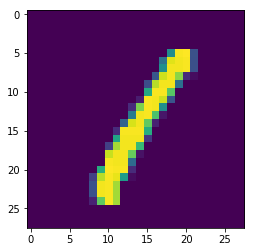

In [56]:
from matplotlib import pyplot as plt
plt.imshow(origin_train_data.data.numpy()[3], interpolation='nearest')
plt.show()

In [77]:
# flatten the numbers to be crabs, and normalize the data
num_train_data = origin_train_data.data.view(60000, -1).numpy() / 256
num_test_data = origin_test_data.data.view(10000, -1).numpy() / 256
num_train_label = origin_train_data.targets.numpy()
num_test_label = origin_test_data.targets.numpy()

In [211]:
september, october, november = np.random.rand(300), np.random.rand(300), np.random.rand(300)
months = [september, october, november]

In [212]:
train_size = 5958 # 1986
test_size = 1008 # 336

data_train_month = np.array([months[i // 1986] for i in range(train_size)])
data_test_month = np.array([months[i // 336] for i in range(test_size)])

use_numbers = [1, 2, 3]

train_sets = [num_train_data[num_train_label == n][:train_size] for n in use_numbers]
test_sets = [num_test_data[num_test_label == n][:test_size] for n in use_numbers]


In [213]:
train_data = np.array([np.concatenate([train_sets[i], data_train_month], axis = 1) for i in range(3)])
test_data = np.array([np.concatenate([test_sets[i], data_test_month], axis = 1) for i in range(3)])

In [214]:
train_data = np.transpose(train_data, [1, 0, 2])
test_data = np.transpose(test_data, [1, 0, 2])

In [215]:
def make_label(is_train, indx):
    total_size = 1986 if is_train else 336
    month = (indx // total_size) # 0 Sep, 1 Oct, 2 Nov 
    base = np.random.rand() / 4 # shows personal perfer
    low, middle, high = np.random.rand() * 0.25 + 0.1 + base, np.random.rand() * 0.2 + 0.3 + base, np.random.rand() * 0.25 + 0.45 + base
    #low in 0.1 to 0.35 middle in 0.3 to 0.5 high in 0.45 to 0.7 
    return {0: [low, high, middle], 1: [low, middle, high], 2: [high, low, middle]}[month]

In [216]:
train_label = np.array([make_label(True, i) for i in range(train_data.shape[0])])
test_label = np.array([make_label(False, i) for i in range(test_data.shape[0])])

In [217]:
import seaborn as sn

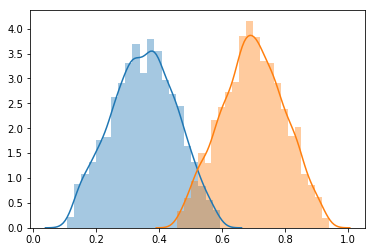

In [218]:
for i in range(2):
    sn.distplot(train_label[:1986, i])



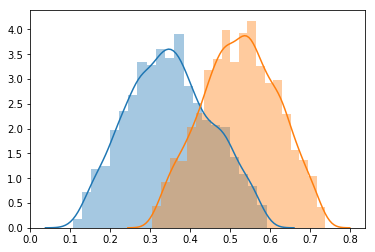

In [219]:
for i in range(2):
    sn.distplot(train_label[1986: 1986 * 2, i])

In [2]:
from torch.autograd import Variable

In [2]:
from torch.nn.functional import softmax

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as Data


In [274]:
class L2RNet(nn.Module):
    def __init__(self):
        super(L2RNet, self).__init__()
        
        self.h1 = nn.Linear(1084, 256)
        self.h2 = nn.Linear(256, 64)
        self.h3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.h3(x)
        return F.softmax(x.view(x.size(0), x.size(1)), dim = 1)

    
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        
        self.h1 = nn.Linear(1084, 256)
        self.h2 = nn.Linear(256, 64)
        self.h3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.h3(x)
        return F.tanh(x.view(x.size(0), x.size(1)))

In [244]:
m = L2RNet()

In [248]:
optimizer = optim.Adam(m.parameters(), lr = 1e-4)
loader = Data.DataLoader(Data.TensorDataset(torch.FloatTensor(train_data), torch.FloatTensor(train_label)), 
                        batch_size = 250, shuffle = True)

In [261]:
for _ in range(1):
    for _, (x, y) in enumerate(loader):
        
        x, y = Variable(x), Variable(y)
        oup = m(x)
        loss = torch.mean(-y * torch.log(oup))
        #loss = torch.mean((y - oup) ** 2)
        print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

tensor(0.5609, grad_fn=<MeanBackward0>)
tensor(0.5643, grad_fn=<MeanBackward0>)
tensor(0.5575, grad_fn=<MeanBackward0>)
tensor(0.5599, grad_fn=<MeanBackward0>)
tensor(0.5633, grad_fn=<MeanBackward0>)
tensor(0.5533, grad_fn=<MeanBackward0>)
tensor(0.5516, grad_fn=<MeanBackward0>)
tensor(0.5595, grad_fn=<MeanBackward0>)
tensor(0.5655, grad_fn=<MeanBackward0>)
tensor(0.5658, grad_fn=<MeanBackward0>)
tensor(0.5528, grad_fn=<MeanBackward0>)
tensor(0.5485, grad_fn=<MeanBackward0>)
tensor(0.5553, grad_fn=<MeanBackward0>)
tensor(0.5483, grad_fn=<MeanBackward0>)
tensor(0.5631, grad_fn=<MeanBackward0>)
tensor(0.5568, grad_fn=<MeanBackward0>)
tensor(0.5579, grad_fn=<MeanBackward0>)
tensor(0.5539, grad_fn=<MeanBackward0>)
tensor(0.5523, grad_fn=<MeanBackward0>)
tensor(0.5623, grad_fn=<MeanBackward0>)
tensor(0.5598, grad_fn=<MeanBackward0>)
tensor(0.5596, grad_fn=<MeanBackward0>)
tensor(0.5510, grad_fn=<MeanBackward0>)
tensor(0.5657, grad_fn=<MeanBackward0>)


In [265]:
train_result = m(torch.FloatTensor(train_data)).detach().numpy()
test_result = m(torch.FloatTensor(test_data)).detach().numpy()

In [264]:
np.sum([np.all(np.argsort(train_result[i]) == np.argsort(train_label[i])) for i in range(train_label.shape[0]) ])

5283

In [ ]:
np.sum([np.all(np.argsort(test_result[i]) == np.argsort(test_label[i])) for i in range(test_label.shape[0])])

897

In [275]:
m = FNet()

In [276]:
for _ in range(1):
    for _, (x, y) in enumerate(loader):
        
        x, y = Variable(x), Variable(y)
        oup = m(x)
        #loss = torch.mean(-y * torch.log(oup))
        loss = torch.mean((y - oup) ** 2)
        print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

tensor(0.2848, grad_fn=<MeanBackward0>)
tensor(0.2819, grad_fn=<MeanBackward0>)
tensor(0.2877, grad_fn=<MeanBackward0>)
tensor(0.2793, grad_fn=<MeanBackward0>)
tensor(0.2777, grad_fn=<MeanBackward0>)
tensor(0.2750, grad_fn=<MeanBackward0>)
tensor(0.2781, grad_fn=<MeanBackward0>)
tensor(0.2780, grad_fn=<MeanBackward0>)
tensor(0.2807, grad_fn=<MeanBackward0>)
tensor(0.2716, grad_fn=<MeanBackward0>)
tensor(0.2768, grad_fn=<MeanBackward0>)
tensor(0.2856, grad_fn=<MeanBackward0>)
tensor(0.2784, grad_fn=<MeanBackward0>)
tensor(0.2835, grad_fn=<MeanBackward0>)
tensor(0.2849, grad_fn=<MeanBackward0>)
tensor(0.2778, grad_fn=<MeanBackward0>)
tensor(0.2844, grad_fn=<MeanBackward0>)
tensor(0.2756, grad_fn=<MeanBackward0>)
tensor(0.2819, grad_fn=<MeanBackward0>)
tensor(0.2834, grad_fn=<MeanBackward0>)
tensor(0.2836, grad_fn=<MeanBackward0>)
tensor(0.2817, grad_fn=<MeanBackward0>)
tensor(0.2771, grad_fn=<MeanBackward0>)
tensor(0.2796, grad_fn=<MeanBackward0>)


In [277]:
train_result = m(torch.FloatTensor(train_data)).detach().numpy()

In [278]:
np.sum([np.all(np.argsort(train_result[i]) == np.argsort(train_label[i])) for i in range(train_label.shape[0]) ])

1316